In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, rcParams, style
style.use('seaborn-darkgrid')
import seaborn as sns
sns.set_style('darkgrid')
from plotly import express as px, graph_objects as go

#!pip uninstall statsmodels

from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor

from IPython.display import display
import gc
gc.enable()
from warnings import filterwarnings, simplefilter
filterwarnings('ignore')
simplefilter('ignore')

In [ ]:
!pip install statsmodels
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.graphics.tsaplots import plot_pacf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
rcParams['figure.figsize'] = (12, 9) # Konfigurasi jendela figure

In [ ]:
path = '/content/drive/MyDrive/資料分析與學習基石/DA_group_project/'

In [ ]:
train = pd.read_csv(
    path + 'archive/train.csv',
    parse_dates=['date'], infer_datetime_format=True,
    dtype={'store_nbr': 'category', 'family': 'category'},
    usecols=['date', 'store_nbr', 'family', 'sales']
)

train['date'] = train.date.dt.to_period('D')
train = train.set_index(['date', 'store_nbr', 'family']).sort_index()
train

sales
date       store_nbr family                              
2013-01-01 1         AUTOMOTIVE                     0.000
                     BABY CARE                      0.000
                     BEAUTY                         0.000
                     BEVERAGES                      0.000
                     BOOKS                          0.000
...                                                   ...
2017-08-15 9         POULTRY                      438.133
                     PREPARED FOODS               154.553
                     PRODUCE                     2419.729
                     SCHOOL AND OFFICE SUPPLIES   121.000
                     SEAFOOD                       16.000

[3000888 rows x 1 columns]

In [ ]:
calendar = pd.DataFrame(index = pd.date_range('2013-01-01', '2017-08-31')).to_period('D')

oil = pd.read_csv(
    path + 'archive/oil.csv',
    parse_dates = ['date'], infer_datetime_format = True,
    index_col = 'date'
).to_period('D')

oil['avg_oil'] = oil['dcoilwtico'].rolling(7).mean()
calendar = calendar.join(oil.avg_oil)
calendar['avg_oil'].fillna(method='ffill', inplace=True)
calendar.dropna(inplace = True)

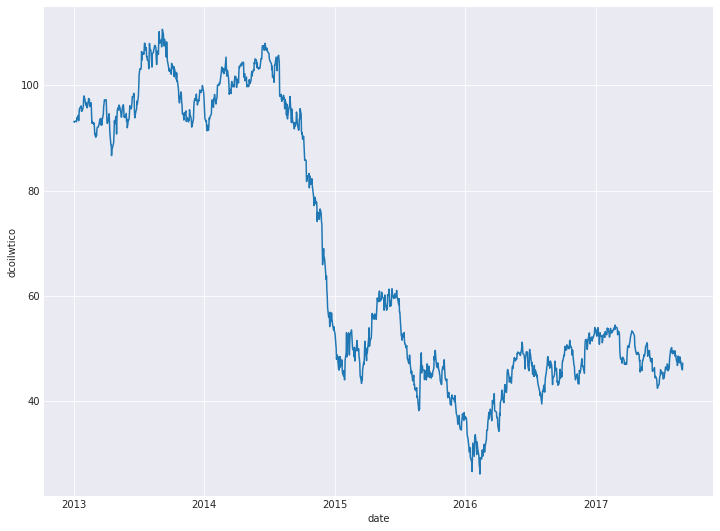

In [ ]:
_ = sns.lineplot(data = oil.dcoilwtico.to_timestamp())

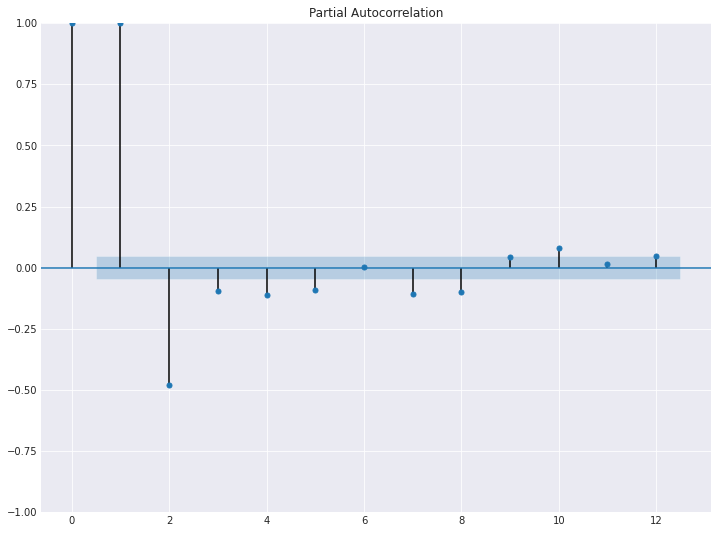

In [ ]:
_ = plot_pacf(calendar.avg_oil, lags = 12) # Lagplot oil price (Feature Engineering)

In [ ]:
n_lags = 3
for lag in range(1, n_lags + 1) :
    calendar[f'oil_lags{lag}'] = calendar.avg_oil.shift(lag)
calendar.dropna(inplace = True)
calendar

,avg_oil,oil_lags1,oil_lags2,oil_lags3
2013-01-13,93.284286,93.284286,93.284286,93.218571
2013-01-14,93.470000,93.284286,93.284286,93.284286
2013-01-15,93.490000,93.470000,93.284286,93.284286
2013-01-16,93.644286,93.490000,93.470000,93.284286
2013-01-17,93.970000,93.644286,93.490000,93.470000
...,...,...,...,...
2017-08-27,47.720000,47.720000,47.720000,47.598571
2017-08-28,47.624286,47.720000,47.720000,47.720000
2017-08-29,47.320000,47.624286,47.720000,47.720000
2017-08-30,47.115714,47.320000,47.624286,47.720000


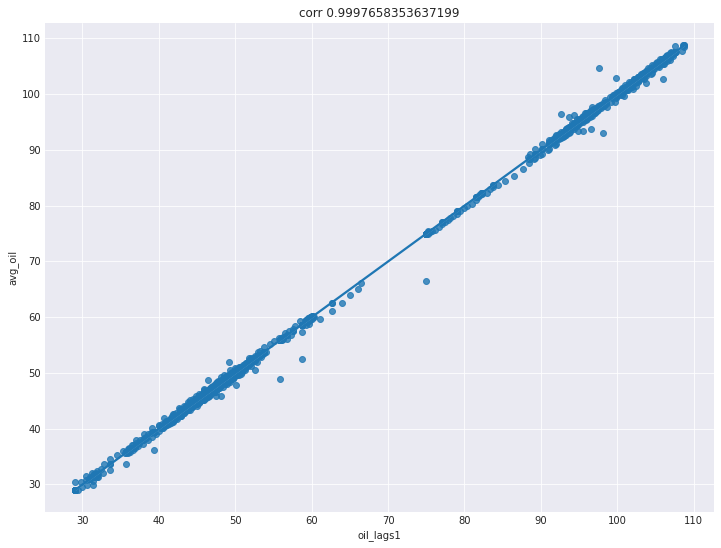

In [ ]:
lag = 'oil_lags1'
plt.figure()
sns.regplot(x = calendar[lag], y = calendar.avg_oil)
plt.title(f'corr {calendar.avg_oil.corr(calendar[lag])}')
plt.show()

In [ ]:
hol = pd.read_csv(
    path + 'archive/holidays_events.csv',
    parse_dates = ['date'], 
    infer_datetime_format=True,
    index_col='date'
).to_period('D')

hol = hol[hol.locale == 'National'] # I'm only taking National holiday so there's no false positive.
hol = hol.groupby(hol.index).first() # Removing duplicated holiday at the same date
hol

,type,locale,locale_name,description,transferred
date,,,,,
2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False
...,...,...,...,...,...
2017-12-22,Additional,National,Ecuador,Navidad-3,False
2017-12-23,Additional,National,Ecuador,Navidad-2,False
2017-12-24,Additional,National,Ecuador,Navidad-1,False


In [ ]:
calendar = calendar.join(hol) # Joining calendar with holiday dataset
calendar['dofw'] = calendar.index.dayofweek # Weekly day
calendar['wd'] = 1
calendar.loc[calendar.dofw > 4, 'wd'] = 0 # If it's saturday or sunday then it's not Weekday
calendar.loc[calendar.type == 'Work Day', 'wd'] = 1 # If it's Work Day event then it's a workday
calendar.loc[calendar.type == 'Transfer', 'wd'] = 0 # If it's Transfer event then it's not a work day
calendar.loc[calendar.type == 'Bridge', 'wd'] = 0 # If it's Bridge event then it's not a work day
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'wd'] = 0 # If it's holiday and the holiday is not transferred then it's holiday
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == True), 'wd'] = 1 # If it's holiday and transferred then it's not holiday
calendar = pd.get_dummies(calendar, columns = ['dofw'], drop_first = True) # One-hot encoding (Make sure to drop one of the columns by 'drop_first = True')
calendar = pd.get_dummies(calendar, columns = ['type']) # One-hot encoding for type holiday (No need to drop one of the columns because there's a "No holiday" already)
calendar.drop(['locale', 'locale_name', 'description', 'transferred'], axis = 1, inplace = True) # Unused columns
calendar

,avg_oil,oil_lags1,oil_lags2,oil_lags3,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day
2013-01-13,93.284286,93.284286,93.284286,93.218571,0,0,0,0,0,0,1,0,0,0,0,0,0
2013-01-14,93.470000,93.284286,93.284286,93.284286,1,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-15,93.490000,93.470000,93.284286,93.284286,1,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-16,93.644286,93.490000,93.470000,93.284286,1,0,1,0,0,0,0,0,0,0,0,0,0
2013-01-17,93.970000,93.644286,93.490000,93.470000,1,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,47.720000,47.720000,47.720000,47.598571,0,0,0,0,0,0,1,0,0,0,0,0,0
2017-08-28,47.624286,47.720000,47.720000,47.720000,1,0,0,0,0,0,0,0,0,0,0,0,0
2017-08-29,47.320000,47.624286,47.720000,47.720000,1,1,0,0,0,0,0,0,0,0,0,0,0
2017-08-30,47.115714,47.320000,47.624286,47.720000,1,0,1,0,0,0,0,0,0,0,0,0,0


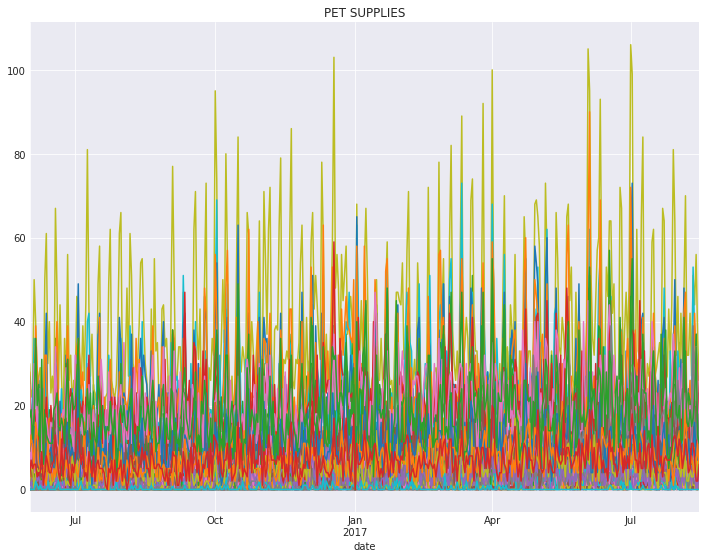

In [ ]:
y = train.unstack(['store_nbr', 'family']).loc['2016-06':'2017']
family = {c[2] for c in train.index}

for f in family :
    ax = y.loc(axis = 1)['sales', :, f].plot(legend = None)
    ax.set_title(f)
    break

# start and end of training date

In [ ]:
sdate = '2017-04-30' # start of training date
edate = '2017-08-15' # end of training date

In [ ]:
school_season = [] # Feature for school fluctuations

for i, r in calendar.iterrows() :
    if i.month in [4, 5, 8, 9] :
        school_season.append(1)
    else :
        school_season.append(0)

calendar['school_season'] = school_season
calendar

,avg_oil,oil_lags1,oil_lags2,oil_lags3,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,school_season
2013-01-13,93.284286,93.284286,93.284286,93.218571,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2013-01-14,93.470000,93.284286,93.284286,93.284286,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-15,93.490000,93.470000,93.284286,93.284286,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-16,93.644286,93.490000,93.470000,93.284286,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-17,93.970000,93.644286,93.490000,93.470000,1,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,47.720000,47.720000,47.720000,47.598571,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2017-08-28,47.624286,47.720000,47.720000,47.720000,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2017-08-29,47.320000,47.624286,47.720000,47.720000,1,1,0,0,0,0,0,0,0,0,0,0,0,1
2017-08-30,47.115714,47.320000,47.624286,47.720000,1,0,1,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
y = train.unstack(['store_nbr', 'family']).loc[sdate:edate]
fourier = CalendarFourier(freq = 'W', order = 4)
dp = DeterministicProcess(
    index=y.index,
    order=1,
    seasonal=False,
    constant=False,
    additional_terms=[fourier],
    drop=True
)

x = dp.in_sample()
x = x.join(calendar)
x

,trend,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",avg_oil,oil_lags1,oil_lags2,...,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,school_season
date,,,,,,,,,,,,,,,,,,,,,
2017-04-30,1.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,49.358571,49.358571,49.358571,...,0,0,1,0,0,0,0,0,0,1
2017-05-01,2.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,49.154286,49.358571,49.358571,...,0,0,0,0,0,0,1,0,0,1
2017-05-02,3.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,48.870000,49.154286,49.358571,...,0,0,0,0,0,0,0,0,0,1
2017-05-03,4.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,48.711429,48.870000,49.154286,...,0,0,0,0,0,0,0,0,0,1
2017-05-04,5.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,48.187143,48.711429,48.870000,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,104.0,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,49.140000,49.252857,49.345714,...,1,0,0,0,0,0,0,1,0,1
2017-08-12,105.0,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490,49.140000,49.140000,49.252857,...,0,1,0,0,0,0,0,0,0,1
2017-08-13,106.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,49.140000,49.140000,49.140000,...,0,0,1,0,0,0,0,0,0,1


In [ ]:
print(y.isna().sum().sum())
#display(y)

0


# predicting next x days

In [ ]:
xtest = dp.out_of_sample(steps=16)
xtest = xtest.join(calendar)
xtest

,trend,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",avg_oil,oil_lags1,oil_lags2,...,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,school_season
2017-08-16,109.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,48.281429,48.648571,48.934286,...,0,0,0,0,0,0,0,0,0,1
2017-08-17,110.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,47.995714,48.281429,48.648571,...,0,0,0,0,0,0,0,0,0,1
2017-08-18,111.0,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,47.852857,47.995714,48.281429,...,1,0,0,0,0,0,0,0,0,1
2017-08-19,112.0,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490,47.852857,47.852857,47.995714,...,0,1,0,0,0,0,0,0,0,1
2017-08-20,113.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,47.852857,47.852857,47.852857,...,0,0,1,0,0,0,0,0,0,1
2017-08-21,114.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,47.688571,47.852857,47.852857,...,0,0,0,0,0,0,0,0,0,1
2017-08-22,115.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,47.522857,47.688571,47.852857,...,0,0,0,0,0,0,0,0,0,1
2017-08-23,116.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,47.645714,47.522857,47.688571,...,0,0,0,0,0,0,0,0,0,1
2017-08-24,117.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,47.598571,47.645714,47.522857,...,0,0,0,0,0,0,0,0,0,1
2017-08-25,118.0,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,47.720000,47.598571,47.645714,...,1,0,0,0,0,0,0,0,0,1


In [ ]:
def make_lags(x, lags = 1) : #Fungsi untuk membuat fitur lags
    lags = lags
    x_ = x.copy()
    for i in range(lags) :
        lag = x_.shift(i + 1)
        x = pd.concat([x, lag], axis = 1)
    return x

In [ ]:
from joblib import Parallel, delayed
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

In [ ]:
lnr = LinearRegression(fit_intercept = True, n_jobs = -1, normalize = True)
lnr.fit(x, y)

yfit_lnr = pd.DataFrame(lnr.predict(x), index = x.index, columns = y.columns).clip(0.)
ypred_lnr = pd.DataFrame(lnr.predict(xtest), index = xtest.index, columns = y.columns).clip(0.)

svr = MultiOutputRegressor(SVR(C = 0.2, kernel = 'rbf'), n_jobs = -1)
svr.fit(x, y)

yfit_svr = pd.DataFrame(svr.predict(x), index = x.index, columns = y.columns).clip(0.)
ypred_svr = pd.DataFrame(svr.predict(xtest), index = xtest.index, columns = y.columns).clip(0.)

yfit_mean = pd.DataFrame(np.mean([yfit_svr.values, yfit_lnr.values], axis = 0), index = x.index, columns = y.columns).clip(0.)
ypred_mean = pd.DataFrame(np.mean([ypred_lnr.values, ypred_svr.values], axis = 0), index = xtest.index, columns = y.columns).clip(0.)

y_ = y.stack(['store_nbr', 'family'])
y_['lnr'] = yfit_lnr.stack(['store_nbr', 'family'])['sales']
y_['svr'] = yfit_svr.stack(['store_nbr', 'family'])['sales']
y_['mean'] = yfit_mean.stack(['store_nbr', 'family'])['sales']

print('='*70, 'Linear Regression', '='*70)
print(y_.groupby('family').apply(lambda r : np.sqrt(msle(r['sales'], r['lnr']))))
print('LNR RMSLE :', np.sqrt(msle(y, yfit_lnr)))
print('='*70, 'SVR', '='*70)
print(y_.groupby('family').apply(lambda r : np.sqrt(msle(r['sales'], r['svr']))))
print('SVR RMSLE :', np.sqrt(msle(y, yfit_svr)))
print('='*70, 'Mean', '='*70)
print(y_.groupby('family').apply(lambda r : np.sqrt(msle(r['sales'], r['mean']))))
print('Mean RMSLE :', np.sqrt(msle(y, yfit_mean)))

====================================================================== Linear Regression ======================================================================
family
AUTOMOTIVE                    0.470953
BABY CARE                     0.253725
BEAUTY                        0.470013
BEVERAGES                     0.165701
BOOKS                         0.124115
BREAD/BAKERY                  0.133141
CELEBRATION                   0.512125
CLEANING                      0.325909
DAIRY                         0.122254
DELI                          0.152218
EGGS                          0.281778
FROZEN FOODS                  0.243512
GROCERY I                     0.147955
GROCERY II                    0.548617
HARDWARE                      0.491726
HOME AND KITCHEN I            0.457245
HOME AND KITCHEN II           0.449896
HOME APPLIANCES               0.363741
HOME CARE                     0.192405
LADIESWEAR                    0.447912
LAWN AND GARDEN               0.398217
LINGERIE      

In [ ]:
from sklearn.metrics import mean_absolute_error as mae

print('='*70, 'Linear Regression', '='*70)
print(y_.groupby('family').apply(lambda r : mae(r['sales'], r['lnr'])))
print('LNR RMSLE :', mae(y, yfit_lnr))
print('='*70, 'SVR', '='*70)
print(y_.groupby('family').apply(lambda r : mae(r['sales'], r['svr'])))
print('SVR RMSLE :', mae(y, yfit_svr))
print('='*70, 'Mean', '='*70)
print(y_.groupby('family').apply(lambda r : mae(r['sales'], r['mean'])))
print('Mean RMSLE :', mae(y, yfit_mean))

====================================================================== Linear Regression ======================================================================
family
AUTOMOTIVE                      2.462666
BABY CARE                       0.218935
BEAUTY                          1.993658
BEVERAGES                     393.223348
BOOKS                           0.062452
BREAD/BAKERY                   48.987934
CELEBRATION                     4.508831
CLEANING                      234.958095
DAIRY                          77.517478
DELI                           35.185488
EGGS                           29.019481
FROZEN FOODS                   19.628004
GROCERY I                     488.737700
GROCERY II                      8.638179
HARDWARE                        0.944746
HOME AND KITCHEN I             10.298440
HOME AND KITCHEN II             9.755713
HOME APPLIANCES                 0.467302
HOME CARE                      39.605771
LADIESWEAR                      3.409966
LAWN AND GARD

In [ ]:
true_low = [2]
pred_low = [4]

print('RMSLE for low value :', np.sqrt(msle(true_low, pred_low)))
print('MAE for low value :', mae(true_low, pred_low))

true_high = [255]
pred_high = [269]

print('RMSLE for high value :', np.sqrt(msle(true_high, pred_high)))
print('MAE for high value :', mae(true_high, pred_high))

RMSLE for low value : 0.5108256237659907
MAE for low value : 2.0
RMSLE for high value : 0.053244514518812736
MAE for high value : 14.0


In [ ]:
#display(x, xtest)

In [ ]:
#ypred_svr

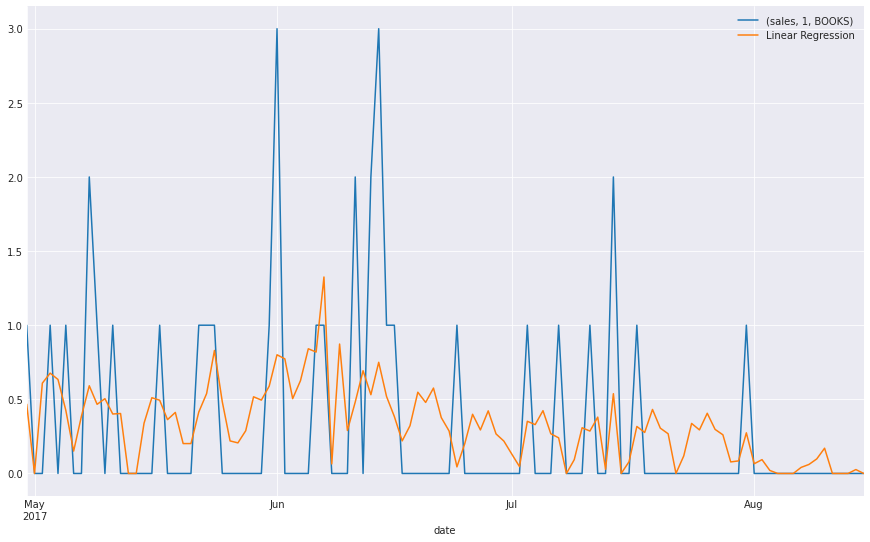

In [ ]:
fam = 'BOOKS'
nbr = '1'
plt.rcParams['figure.figsize'] = (15, 9)
plt.figure()
y.loc(axis = 1)['sales', nbr, fam].plot()
yfit_lnr.loc(axis = 1)['sales', nbr, fam].plot(label = 'Linear Regression')
plt.legend()
plt.show()

In [ ]:
ymean = yfit_lnr.append(ypred_lnr)
school = ymean.loc(axis = 1)['sales', :, 'SCHOOL AND OFFICE SUPPLIES']
ymean = ymean.join(school.shift(1), rsuffix = 'lag1') # I'm also adding school lag for it's cyclic yearly.
x = x.loc['2017-05-01':]

In [ ]:
ymean.loc['2017-08-16':]

sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
2017-08-16   3.555439       0.0  5.867603  2177.101514  0.051118   375.696460   
2017-08-17   3.157970       0.0  5.351209  1820.884426  0.000000   325.401119   
2017-08-18   7.196938       0.0  4.625604  2226.318076  0.000000   360.358263   
2017-08-19   5.081869       0.0  5.161570  2110.332182  0.000000   324.401823   
2017-08-20   1.890016       0.0  3.552465   791.784055  0.000000   122.069647   
2017-08-21   3.861995       0.0  5.501442  2086.850066  0.000000   350.405306   
2017-08-22   3.870789       0.0  5.098935  2142.494108  0.000000   331.975768   
2017-08-23   3.805114       0.0  5.927498  2152.189495  0.000000   374.242688   
2017-08-24   3.201296       0.0  5.033964  1831.757276  0.000000   320.689802   
2017-08-25   7.808126       0.0  4.222571  2217.743153  0.000000   353.374110   
2017-08-26   5.231181       0.0  4.950071  2107.504993  0.000000   317.896659   
2017-08-27   2.180226       0.0  3.556282   766.607195  0.000000   116.138004   
2017-08-28   3.932675       0.0  5.609625  2067.059825  0.000000   346.750075   
2017-08-29   3.741585       0.0  5.253178  2125.002831  0.000000   327.227568   
2017-08-30   3.644864       0.0  6.388955  2108.349389  0.000000   369.009468   
2017-08-31   3.123013       0.0  5.688508  1774.781559  0.000000   319.225734   

                                                            ...  \
store_nbr                                                   ...   
family     CELEBRATION    CLEANING       DAIRY        DELI  ...   
2017-08-16   11.756877  779.982765  752.610908  129.768023  ...   
2017-08-17   15.747843  628.491312  624.809458  104.609074  ...   
2017-08-18   20.469747  728.116520  716.495682  156.243850  ...   
2017-08-19    7.636518  539.945260  662.092677  119.326347  ...   
2017-08-20    0.097264  178.957080  253.856888   52.230572  ...   
2017-08-21   12.736230  623.359988  666.356287  130.122288  ...   
2017-08-22   13.355477  713.785441  628.262960  120.187712  ...   
2017-08-23   10.957510  763.748820  752.490447  131.933947  ...   
2017-08-24   15.773635  634.643890  623.590801  106.863516  ...   
2017-08-25   20.573355  720.721964  695.138657  154.320026  ...   
2017-08-26    7.958857  543.838133  647.497795  117.678711  ...   
2017-08-27    0.213854  172.204935  233.372825   48.677959  ...   
2017-08-28   12.314884  613.874927  658.484449  129.544403  ...   
2017-08-29   13.494781  715.868687  618.058973  118.169007  ...   
2017-08-30   11.565713  766.961506  732.350335  125.942548  ...   
2017-08-31   15.283280  618.676504  614.524159  103.990658  ...   

                            saleslag1                             \
store_nbr                           5                         50   
family     SCHOOL AND OFFICE SUPPLIES SCHOOL AND OFFICE SUPPLIES   
2017-08-16                   0.345785                 411.618497   
2017-08-17                   0.000000                 440.824152   
2017-08-18                   0.000000                 435.374646   
2017-08-19                   0.000000                 449.440922   
2017-08-20                   0.315319                 437.937342   
2017-08-21                   1.205412                 446.159783   
2017-08-22                   0.378067                 406.630975   
2017-08-23                   0.193043                 422.207132   
2017-08-24                   0.000000                 435.801024   
2017-08-25                   0.150977                 430.827593   
2017-08-26                   0.000000                 441.381906   
2017-08-27                   0.140258                 449.345193   
2017-08-28                   0.880380                 464.320926   
2017-08-29                   0.172141                 431.022632   
2017-08-30                   0.000000         

In [ ]:
x = x.join(ymean) # Concating linear result
xtest = xtest.join(ymean)
#display(x, xtest)

In [ ]:
y = y.loc['2017-05-01':]
y

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-05-01        0.0       0.0    2.0     825.0   0.0    116.33900   
2017-05-02        2.0       0.0    2.0    3179.0   0.0    447.23800   
2017-05-03        5.0       0.0    6.0    2479.0   1.0    434.02900   
2017-05-04        3.0       0.0    1.0    2454.0   0.0    438.21400   
2017-05-05       12.0       0.0    0.0    2243.0   1.0    398.96500   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0    145.60700   
2017-08-12        6.0       0.0    3.0    1659.0   0.0    243.22000   
2017-08-13        1.0       0.0    1.0     803.0   0.0    136.67900   
2017-08-14        1.0       0.0    6.0    2201.0   0.0    346.03800   
2017-08-15        4.0       0.0    4.0    1942.0   0.0    329.54102   

                                                 ...                     \
store_nbr                                        ...         9            
family     CELEBRATION CLEANING  DAIRY     DELI  ... MAGAZINES    MEATS   
date                                             ...                      
2017-05-01         2.0    227.0  326.0   52.673  ...       5.0  603.395   
2017-05-02        20.0   1061.0  897.0  172.269  ...       0.0  495.275   
2017-05-03        22.0   1117.0  927.0  165.995  ...       4.0  386.662   
2017-05-04        15.0    956.0  755.0  133.780  ...       1.0  601.754   
2017-05-05        15.0    829.0  882.0  149.824  ...       2.0  317.190   
...                ...      ...    ...      ...  ...       ...      ...   
2017-08-11         4.0    341.0  343.0   64.302  ...       5.0  309.245   
2017-08-12         3.0    351.0  526.0   99.488  ...       2.0  260.298   
2017-08-13         1.0    169.0  266.0   47.770  ...       3.0  327.206   
2017-08-14         4.0    571.0  699.0  154.578  ...      12.0  330.975   
2017-08-15        21.0    703.0  602.0  116.402  ...      11.0  449.228   

                                                                          \
store_nbr                                                                  
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS    POULTRY   
date                                                                       
2017-05-01         950.0         19.0                    18.0  615.89800   
2017-05-02         744.0         10.0                    13.0  346.34400   
2017-05-03         513.0          5.0                    11.0  432.57900   
2017-05-04         487.0          4.0                    13.0  312.41100   
2017-05-05         406.0          5.0                    10.0  549.41003   
...                  ...          ...                     ...        ...   
2017-08-11         373.0         11.0                     2.0  525.22400   
2017-08-12         400.0          7.0                    10.0  383.38700   
2017-08-13         510.0          2.0                     9.0  412.45800   
2017-08-14         445.0          2.0                    14.0  283.42900   
2017-08-15         522.0          6.0                     6.0  438.13300   

                                                                           
store_nbr                                                                  
family     PREPARED FOODS   PRODUCE SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date                                                                       
2017-05-01     175.991000  2502.085                        1.0  54.162000  
2017-05-02     105.046000  2739.654                        5.0  21.362000  
2017-05-03      88.384000  1442.451                        4.0  16.125000  
2017-05-04     104.670000  1285.772                        4.0  11.476000  
2017-05-05      94.576996  1167.614                        6.0  18.194000  

In [ ]:
print(y.isna().sum().sum())
#display(x, xtest)

0


In [ ]:
from joblib import Parallel, delayed
import warnings

# Import necessary library
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor

from xgboost import XGBRegressor
!pip install catboost
from catboost import CatBoostRegressor

# SEED for reproducible result
SEED = 5

class CustomRegressor():
    
    def __init__(self, n_jobs=-1, verbose=0):
        
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.estimators_ = None

    def _estimator_(self, X, y):
        warnings.simplefilter(action='ignore', category=FutureWarning)
        # Because SCHOOL AND OFFICE SUPPLIES has weird trend, we use decision tree instead.
        if y.name[2] == 'SCHOOL AND OFFICE SUPPLIES': 
            print('not ridge')
            r1 = ExtraTreesRegressor(n_estimators = 225, n_jobs=-1, random_state=SEED)
            #r2 = RandomForestRegressor(n_estimators = 225, n_jobs=-1, random_state=SEED)
            r2 = CatBoostRegressor(n_estimators=225)
            b1 = BaggingRegressor(base_estimator=r1, n_estimators=10, n_jobs=-1, random_state=SEED)
            #b1 = CatBoostRegressor()
            b2 = BaggingRegressor(base_estimator=r2, n_estimators=10, n_jobs=-1, random_state=SEED)
            #b2 = XGBRegressor(n_jobs=-1)
            model = VotingRegressor([('extraTree', b1), ('rForest', b2)]) # Averaging the result
        else:
            print('ridge')
            ridge = Ridge(fit_intercept=True, solver='auto', alpha=0.75, normalize=True, random_state=SEED)
            svr = SVR(C=0.2, kernel='rbf')
            model = VotingRegressor([('ridge', ridge), ('svr', svr)]) # Averaging result
        
        model.fit(X, y)

        return model

    def fit(self, X, y):
        from tqdm.auto import tqdm
        if self.verbose == 0 :
            self.estimators_ = Parallel(
                n_jobs=self.n_jobs, 
                verbose=0,
                )(delayed(self._estimator_)(X, y.iloc[:, i]) for i in range(y.shape[1]))
        else :
            print('Fit Progress')
            self.estimators_ = Parallel(n_jobs=self.n_jobs, 
                                  verbose=0,
                                  )(delayed(self._estimator_)(X, y.iloc[:, i]) for i in tqdm(range(y.shape[1])))
        return
    
    def predict(self, X):
        from tqdm.auto import tqdm
        if self.verbose == 0 :
            y_pred = Parallel(
                n_jobs=self.n_jobs, 
                verbose=0)(delayed(e.predict)(X) for e in self.estimators_)
        else :
            print('Predict Progress')
            y_pred = Parallel(n_jobs=self.n_jobs, 
                              verbose=0)(delayed(e.predict)(X) for e in tqdm(self.estimators_))
        
        return np.stack(y_pred, axis=1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%%time

model = CustomRegressor(n_jobs=-1, verbose=1)
model.fit(x, y)
y_pred = pd.DataFrame(model.predict(x), index=x.index, columns=y.columns)

Fit Progress


  0%|          | 0/1782 [00:00<?, ?it/s]

CatBoostError: ignored

In [ ]:
#display(y_pred)
print(y_pred.isna().sum().sum())

sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-05-01   1.698524       0.0  2.173227  1579.802698  0.054388   245.079779   
2017-05-02   3.004028       0.0  2.616627  2680.868116  0.177364   409.074859   
2017-05-03   3.521669       0.0  3.814092  2386.076368  0.404251   407.459876   
2017-05-04   3.257565       0.0  3.335985  2214.912187  0.331597   382.893081   
2017-05-05   5.520494       0.0  3.073227  2386.152081  0.267680   397.429907   
...               ...       ...       ...          ...       ...          ...   
2017-08-11   2.418747       0.0  2.013310  1636.205361 -0.022421   260.527651   
2017-08-12   4.411518       0.0  3.135655  2173.003408 -0.047607   331.894410   
2017-08-13   3.088893       0.0  2.752154  1598.121771 -0.034620   251.354349   
2017-08-14   4.142985       0.0  4.142910  2239.278581  0.101574   364.541466   
2017-08-15   4.359934       0.0  3.894137  2237.649700  0.063734   354.972784   

                                                            ...            \
store_nbr                                                   ...         9   
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
date                                                        ...             
2017-05-01    6.665377  464.456684  536.423873   92.454834  ...  4.130100   
2017-05-02   17.506828  869.248678  815.394215  147.404291  ...  1.879148   
2017-05-03   15.007739  802.727812  822.494235  142.020816  ...  3.308938   
2017-05-04   17.715773  741.567528  755.765013  127.999408  ...  3.105408   
2017-05-05   19.571560  772.173268  796.826660  148.837223  ...  3.029257   
...                ...         ...         ...         ...  ...       ...   
2017-08-11    8.674905  495.346209  533.474522   99.084728  ...  4.284910   
2017-08-12    9.754361  578.910393  675.843784  119.505781  ...  3.158877   
2017-08-13    6.241992  440.141342  510.948518   93.722052  ...  4.017637   
2017-08-14   13.354564  661.571745  716.223948  133.636154  ...  3.718825   
2017-08-15   13.904421  698.959811  684.906657  126.309498  ...  3.934440   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-05-01  483.484179    689.230742    13.833860               14.552034   
2017-05-02  422.695493    559.488011     7.906607               11.326302   
2017-05-03  349.402141    408.586035     6.936659               10.569328   
2017-05-04  447.863820    409.452278     6.222808               10.561030   
2017-05-05  338.028643    382.841693     5.794061                9.746941   
...                ...           ...          ...                     ...   
2017-08-11  333.196417    378.746798     8.300076                5.898847   
2017-08-12  355.142169    468.180256     7.690115                9.944587   
2017-08-13  396.256113    534.225642     8.185608               11.315562   
2017-08-14  344.541873    452.855470     6.369597                8.184443   
2017-08-15  353.177867    452.804729     5.718208                7.151970   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-05-01  527.884650     147.726692  2010.338964                   8.985111   
2017-05-02  385.216490     110.965911  2088.358515                   4.862889   
20

0


In [ ]:
from sklearn.metrics import mean_squared_log_error

y_pred = y_pred.stack(['store_nbr', 'family']).clip(0.)
y_ = y.stack(['store_nbr', 'family']).clip(0.)

y_['pred'] = y_pred.values
print(y_.groupby('family').apply(lambda r : np.sqrt(np.sqrt(mean_squared_log_error(r['sales'], r['pred'])))))
# Looking at error
print('RMSLE : ', np.sqrt(np.sqrt(msle(y_['sales'], y_['pred']))))

family
AUTOMOTIVE                    0.682456
BABY CARE                     0.485725
BEAUTY                        0.678844
BEVERAGES                     0.429658
BOOKS                         0.345595
BREAD/BAKERY                  0.398289
CELEBRATION                   0.706130
CLEANING                      0.508470
DAIRY                         0.393521
DELI                          0.418994
EGGS                          0.532926
FROZEN FOODS                  0.517150
GROCERY I                     0.407054
GROCERY II                    0.707978
HARDWARE                      0.685809
HOME AND KITCHEN I            0.657512
HOME AND KITCHEN II           0.630601
HOME APPLIANCES               0.589133
HOME CARE                     0.453047
LADIESWEAR                    0.656678
LAWN AND GARDEN               0.636974
LINGERIE                      0.750291
LIQUOR,WINE,BEER              0.688461
MAGAZINES                     0.673514
MEATS                         0.445274
PERSONAL CARE     

In [ ]:
ypred = pd.DataFrame(model.predict(xtest), index = xtest.index, columns = y.columns).clip(0.)
ypred

Predict Progress


  0%|          | 0/1782 [00:00<?, ?it/s]

In [ ]:
ypred = ypred.stack(['store_nbr', 'family'])
ypred

# submit

In [ ]:
sub = pd.read_csv(path + 'archive/sample_submission.csv')
sub['sales'] = ypred.values
sub.to_csv(path + 'archive/submission.csv', index=False) # result to submit
sub